In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("trip_count_sql").getOrCreate()

In [5]:
directory="C:/Users/wjswl/study_spark/data"
trip_files = "\\trips\\*"
zone_file = "taxi+_zone_lookup.csv"

In [6]:
trips_df = spark.read.csv(f"file:///{directory}\\{trip_files}", inferSchema=True, header=True)
zone_df = spark.read.csv(f"file:///{directory}\\{zone_file}", inferSchema=True, header=True)

In [7]:
trips_df.printSchema()
zone_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [8]:
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

매번 조인을 이용해 데이터를 합쳐서 관리 하는 것 보다, 한 번 조인해서 사용하는 것이 더 낫다.

In [9]:
query = """
SELECT
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone

FROM
    trips t
LEFT JOIN zone pz ON t.PULocationID = pz.LocationID
LEFT JOIN zone dz ON t.DOLocationID = dz.LocationID
"""

comb_df = spark.sql(query)
comb_df.createOrReplaceTempView("comb")

In [10]:
comb_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [11]:
comb_df.show(5)

+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+-----------------+--------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_time|passenger_count|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|payment_type|      pickup_zone|  dropoff_zone|
+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+-----------------+--------------+
|        2| 2021-03-01|  2021-03-01|          0|           0|              1|          0.0|        3.0|       0.0|         0.0|         4.3|           2|               NV|            NV|
|        2| 2021-03-01|  2021-03-01|          0|           0|              1|          0.0|        2.5|       0.0|         0.0|         3.8|           2|   Manhattanville|Manhattanville|
|        2| 2021-03-01|  2021-03-01|          0|           0|    

In [12]:
spark.sql("SELECT pickup_date, pickup_time FROM comb WHERE pickup_time > 0").show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-02-28|         23|
| 2021-03-01|         22|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
| 2021-03-01|          1|
+-----------+-----------+
only showing top 20 rows



2021년도 데이터를 분석할 예정인데, 2020년 미만의 데이터도 존재할 수 있다! 2020-12-31일 이전 데이터가 있는지 확인

In [13]:
query = """

    SELECT pickup_date, pickup_time
    FROM comb
    WHERE pickup_date < '2020-12-31'

"""

spark.sql(query).show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          1|
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|         16|
| 2009-01-01|         16|
| 2009-01-01|          0|
| 2009-01-01|          0|
+-----------+-----------+
only showing top 20 rows



# Cleaning 작업
- 데이터 정제 작업
- 이상한 데이터를 삭제

**요금(`total_amount`)** 확인

In [14]:
comb_df.select("total_amount").describe().show()

+-------+-----------------+
|summary|     total_amount|
+-------+-----------------+
|  count|         15000700|
|   mean|18.75545205708744|
| stddev|145.7442452805979|
|    min|           -647.8|
|    max|         398469.2|
+-------+-----------------+



택시비의 최솟값이 `min`이 음수인 것도 이상하고, 최댓값 `max`도 4억원..?

**거리(`trip_distance`) 확인**

In [15]:
comb_df.select("trip_distance").describe().show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         15000700|
|   mean|6.628629402627818|
| stddev|671.7293482115828|
|    min|              0.0|
|    max|        332541.19|
+-------+-----------------+



`max`값이 말이 안됨.. 33만 마일..? 손으로 직접 거리를 찍다가 잘못 누른 데이터일 가능이 높다.

**월별(`trips`) 확인**

In [16]:
# DATE_TRUNC('MM') : 월을 추출
query = """
    SELECT
        DATE_TRUNC('MM', c.pickup_date) AS month,
        COUNT(*) AS trips
    FROM comb c
    
    GROUP BY month
    ORDER BY month desc
"""

spark.sql(query).show()

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2029-05-01 00:00:00|      1|
|2021-12-01 00:00:00|      5|
|2021-11-01 00:00:00|      5|
|2021-10-01 00:00:00|      3|
|2021-09-01 00:00:00|      3|
|2021-08-01 00:00:00|     36|
|2021-07-01 00:00:00|2821430|
|2021-06-01 00:00:00|2834204|
|2021-05-01 00:00:00|2507075|
|2021-04-01 00:00:00|2171215|
|2021-03-01 00:00:00|1925130|
|2021-02-01 00:00:00|1371688|
|2021-01-01 00:00:00|1369749|
|2020-12-01 00:00:00|     16|
|2009-01-01 00:00:00|    111|
|2008-12-01 00:00:00|     26|
|2004-04-01 00:00:00|      1|
|2003-01-01 00:00:00|      1|
|2002-12-01 00:00:00|      1|
+-------------------+-------+



In [17]:
comb_df.select("passenger_count").describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          14166672|
|   mean|1.4253783104458126|
| stddev|  1.04432704905968|
|    min|                 0|
|    max|                 9|
+-------+------------------+



In [18]:
# Data 클리닝
query = """

SELECT
    c.*
FROM
    comb c
WHERE c.total_amount < 5000
  AND c.total_amount > 0
  AND c.trip_distance < 100
  AND c.passenger_count < 4
  AND c.pickup_date >= '2021-01-01'
  AND c.pickup_date < '2021-08-01'
"""

cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView("cleaned")

In [19]:
cleaned_df.describe().show()

+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+--------------------+
|summary|          vendor_id|       pickup_time|      dropoff_time|   passenger_count|     trip_distance|       fare_amount|        tip_amount|      tolls_amount|      total_amount|       payment_type|         pickup_zone|        dropoff_zone|
+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+--------------------+
|  count|           13297107|          13297107|          13297107|          13297107|          13297107|          13297107|          13297107|          13297107|          13297107|           13297107|            13297107|            13297107|
|   mean| 1.670889840925

# 시각화와 분석

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## 일 별 trips 수 확인 및 분석

In [21]:
query = """
SELECT
    c.pickup_date,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date
"""

pd_df = spark.sql(query).toPandas()
pd_df

,pickup_date,trips
0,2021-03-22,52415
1,2021-03-07,34374
2,2021-03-21,39659
3,2021-05-27,83211
4,2021-03-14,38738
...,...,...
207,2021-03-30,58625
208,2021-03-27,59735
209,2021-03-29,50624
210,2021-04-27,67953


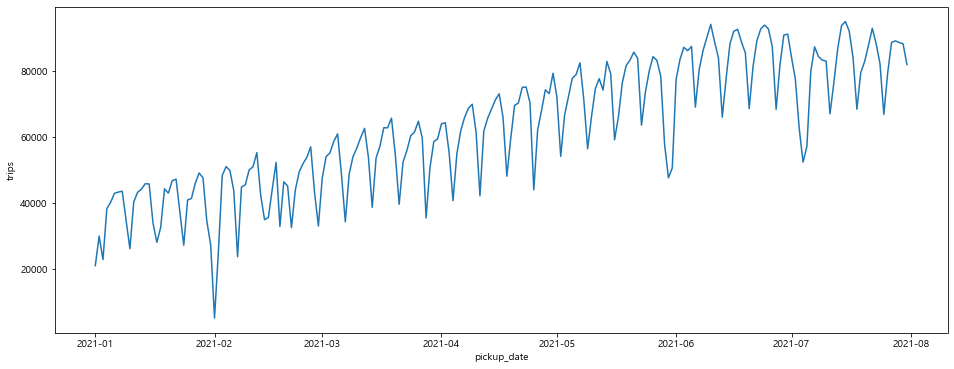

In [22]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(x="pickup_date", y="trips", data=pd_df)
plt.show()

## 요일 별 `trips`의 중간값 확인

In [23]:
# DATE_FORMAT

query = """

SELECT
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') as day_of_week,
    COUNT(*) AS trips
FROM cleaned c

GROUP BY c.pickup_date, day_of_week

"""

pd_df2 = spark.sql(query).toPandas()
pd_df2

,pickup_date,day_of_week,trips
0,2021-03-24,Wednesday,60382
1,2021-03-03,Wednesday,55222
2,2021-03-05,Friday,60984
3,2021-03-09,Tuesday,54085
4,2021-03-26,Friday,64810
...,...,...,...
207,2021-03-30,Tuesday,58625
208,2021-04-24,Saturday,70466
209,2021-03-28,Sunday,35535
210,2021-04-25,Sunday,44048


In [24]:
data = pd_df2.groupby("day_of_week")["trips"].median().to_frame().reset_index()
data

,day_of_week,trips
0,Friday,73094.0
1,Monday,56063.0
2,Saturday,61471.0
3,Sunday,43131.0
4,Thursday,72190.5
5,Tuesday,66821.0
6,Wednesday,69398.5


In [25]:
data["sort_dow"] = data["day_of_week"].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6
})

data

,day_of_week,trips,sort_dow
0,Friday,73094.0,5
1,Monday,56063.0,1
2,Saturday,61471.0,6
3,Sunday,43131.0,0
4,Thursday,72190.5,4
5,Tuesday,66821.0,2
6,Wednesday,69398.5,3


In [26]:
data_sorted = data.sort_values(by="sort_dow")
data_sorted

,day_of_week,trips,sort_dow
3,Sunday,43131.0,0
1,Monday,56063.0,1
5,Tuesday,66821.0,2
6,Wednesday,69398.5,3
4,Thursday,72190.5,4
0,Friday,73094.0,5
2,Saturday,61471.0,6


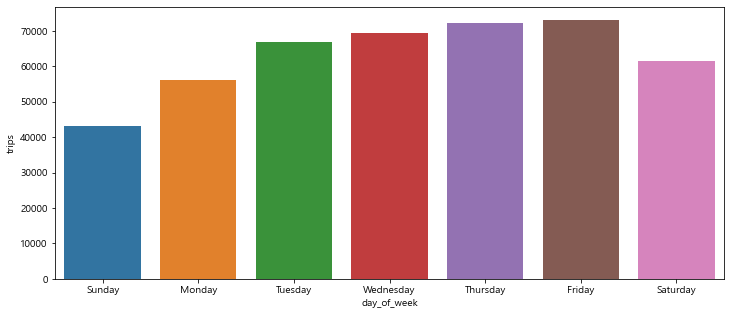

In [27]:
plt.figure(figsize=(12, 5))
sns.barplot(
    x='day_of_week',
    y='trips',
    data=data_sorted
)
plt.show()

## 결제 유형 별 분석하기

In [28]:
payment_type_to_string = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip",
}
def parse_payment_type(payment_type):
    return payment_type_to_string[payment_type]

spark.udf.register("parse_payment_type", parse_payment_type)

<function __main__.parse_payment_type(payment_type)>

In [29]:
query = """
SELECT 
    parse_payment_type(payment_type),
    count(*) AS trips,
    MEAN(fare_amount) AS mean_fare_amount,
    STD(fare_amount) AS stdev_fare_amount
FROM
    cleaned
GROUP BY
    payment_type
"""

spark.sql(query).show()

+--------------------------------+--------+------------------+------------------+
|parse_payment_type(payment_type)|   trips|  mean_fare_amount| stdev_fare_amount|
+--------------------------------+--------+------------------+------------------+
|                     Credit Card|10117869|12.216744280835849|10.795080136078592|
|                       No Charge|   58552|11.931005601858176| 15.03784908925372|
|                         Dispute|   23536|12.653402447314749|14.163477726534882|
|                            Cash| 3097149| 11.98103176179123|11.474101590229465|
|                         Unknown|       1|              17.8|              null|
+--------------------------------+--------+------------------+------------------+



In [37]:
spark.stop()